In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

print(f'GPUs Available: {len(tf.config.list_physical_devices("GPU"))}')

GPUs Available: 1


In [3]:
normal = pd.read_hdf('./data/training_normal.h5')
faulty = pd.read_hdf('./data/training_faulty.h5')
mean = pd.read_hdf('./data/norm.h5', key='mean')
std = pd.read_hdf('./data/norm.h5', key='std')

normal_data = normal.iloc[:, 3:]

normalized_data = (normal_data - mean) / std

normalized_data.head()

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,-0.003307,0.300364,0.514599,-1.342731,-0.062398,0.294726,-0.098047,-0.252914,0.522186,0.089759,...,-0.489006,0.005770,1.001362,-0.150228,-0.078897,1.424527,0.520011,-0.165134,0.284191,0.224294
1,0.019690,-0.128967,1.218404,0.925080,-0.856779,1.091016,-0.005032,-0.000158,0.522186,-0.068269,...,-1.191637,-0.016944,-1.639727,-0.250199,0.078954,0.153478,-1.208816,-0.195688,0.470946,-0.631769
2,-0.003307,-0.102502,-0.791010,1.114064,-0.128596,-1.224631,0.154424,-0.422647,1.045513,-0.113762,...,0.816185,0.008733,-0.018895,0.308127,0.123493,0.300513,0.070048,-0.180595,0.175097,1.647422
3,-0.023065,-0.073095,0.083646,1.522363,-0.681826,-1.256665,0.287304,0.413106,-0.524468,-0.121743,...,-0.058910,0.028155,-1.159749,0.113845,0.132008,-0.009071,0.428147,-0.110653,0.996077,-0.020296
4,1.411175,0.447396,-0.301407,-0.105001,-0.062398,1.429668,0.008256,0.715675,-0.524468,-0.856811,...,-0.672116,1.368624,-0.467518,-0.508613,-0.596991,1.300424,0.472378,-0.225506,0.744606,0.233859


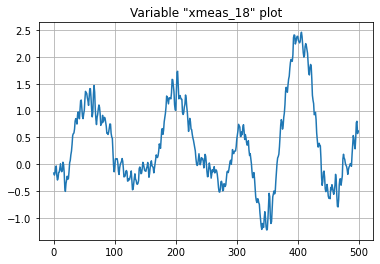

In [4]:
variable = 'xmeas_18'

plt.grid()
plt.plot(normalized_data.index[:500], normalized_data[variable][:500])
plt.title(f'Variable "{variable}" plot')
plt.show()

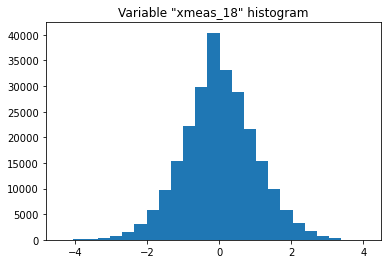

In [5]:
plt.hist(normalized_data[variable], bins=25)
plt.title(f'Variable "{variable}" histogram')
plt.show()

In [6]:
train_data, valid_data = train_test_split(normalized_data.values, test_size=0.2, shuffle=False)
print(f'train data size: {train_data.shape}')
print(f'valid data size: {valid_data.shape}')

input_dim =  train_data.shape[1]

train_data = tf.cast(train_data, tf.float32)
valid_data = tf.cast(valid_data, tf.float32)

train data size: (200000, 52)
valid data size: (50000, 52)


In [ ]:
class Autoencoder(Model):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(32, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(input_dim)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder(input_dim)

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.005), 
              loss=tf.losses.MeanSquaredError(), 
              metrics=[tf.metrics.MeanAbsoluteError()])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.5, 
                                                 patience=5, 
                                                 min_lr=0.0001,
                                                 verbose=1)

In [ ]:
history = model.fit(train_data, train_data, 
                    epochs=150, 
                    batch_size=256, 
                    validation_data=(valid_data, valid_data), 
                    shuffle=True, 
                    callbacks=[reduce_lr])

In [ ]:
# Save model
model.save('saved_model/ae_loss_0967')

In [7]:
# Load model
model = tf.keras.models.load_model('saved_model/ae_loss_0967')

# Evaluate the restored model
mse, mae = model.evaluate(train_data, train_data, batch_size=200000, verbose=2)
print('Restored model, train MSE: {:.4f}'.format(mse))
print()
mse, mae = model.evaluate(valid_data, valid_data, batch_size=50000, verbose=2)
print('Restored model, valid MSE: {:.4f}'.format(mse))

1/1 - 1s - loss: 0.0971 - mean_absolute_error: 0.2088
Restored model, train Mean Squared Error: 0.0971

1/1 - 0s - loss: 0.0969 - mean_absolute_error: 0.2088
Restored model, valid Mean Squared Error: 0.0969


In [8]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('L2 Loss')
plt.legend()

NameError: name 'history' is not defined

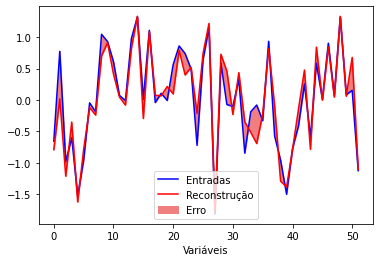

In [9]:
encoded_data = model.encoder(train_data).numpy()
decoded_data = model.decoder(encoded_data).numpy()

index = 100
plt.plot(train_data[index], 'b')
plt.plot(decoded_data[index], 'r')
plt.fill_between(np.arange(52), decoded_data[index], train_data[index], color='lightcoral')
plt.legend(labels=["Entradas", "Reconstrução", "Erro"])
plt.xlabel('Variáveis')
plt.show()

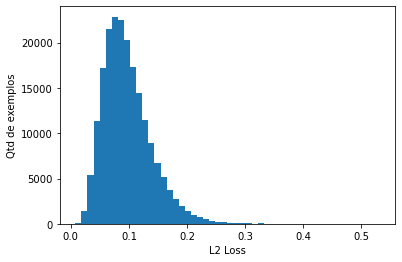

In [10]:
reconstructions = model.predict(train_data)
train_loss = tf.keras.losses.mse(reconstructions, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("L2 Loss")
plt.ylabel("Qtd de exemplos")
plt.show()

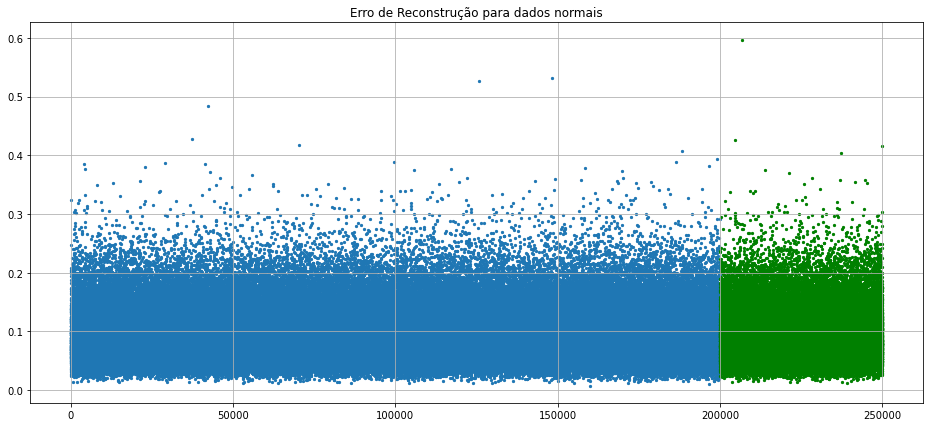

In [11]:
# Run model for normal simulation
reconstructions = model.predict(train_data)
train_loss = tf.keras.losses.mse(reconstructions, train_data)

valid_reconstructions = model.predict(valid_data)
valid_loss = tf.keras.losses.mse(valid_reconstructions, valid_data)

plt.figure(figsize=(16,7))
plt.grid()
plt.scatter(np.arange(200000), train_loss, s=5)
plt.scatter(np.arange(200001, 250001), valid_loss, color='g', s=5)
plt.title(f'Erro de Reconstrução para dados normais')
plt.show()

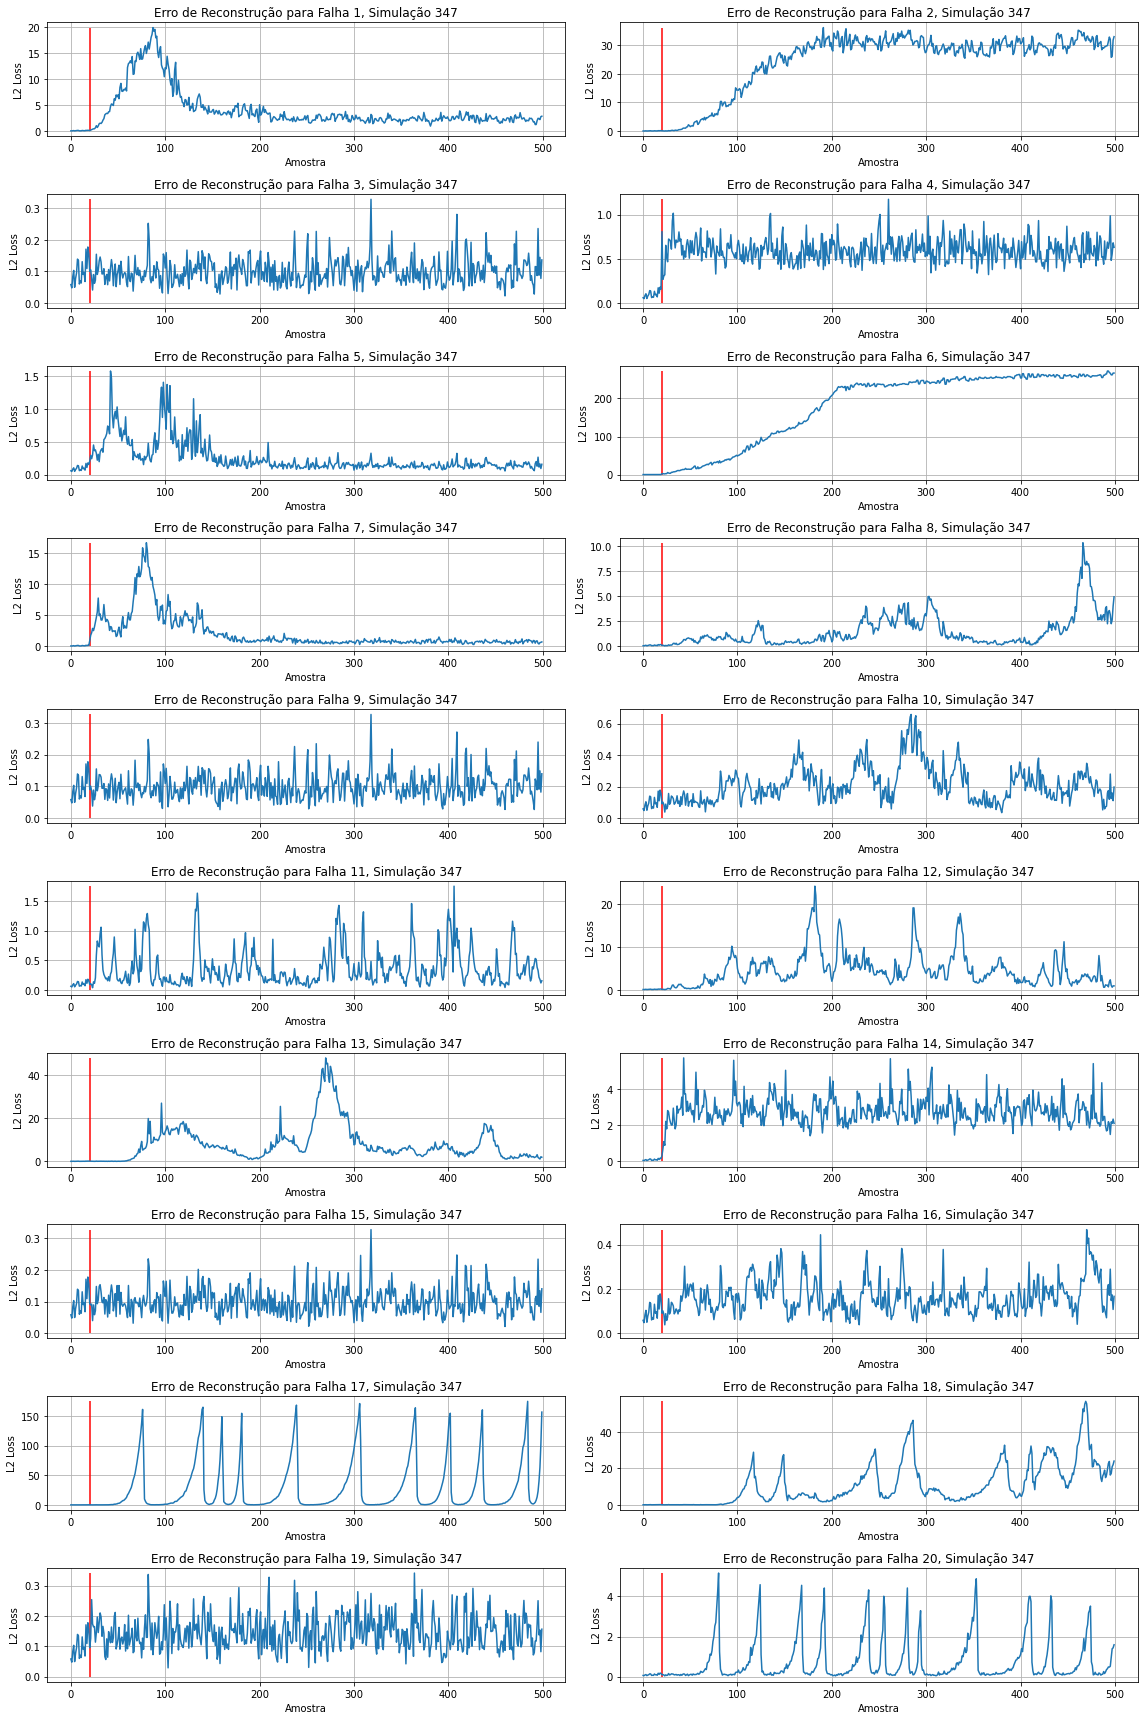

In [13]:
simulationRun = 347
fig, axs = plt.subplots(10, 2, figsize=(16, 24))

for i in range(0, 20):
    row, col = i // 2, i % 2
    
    # Run model for fault simulation
    faultNumber = i+1

    faulty_data = faulty[(faulty['faultNumber'] == faultNumber) & (faulty['simulationRun'] == simulationRun)]
    faulty_data = (faulty_data.iloc[:, 3:] - mean) / std
    faulty_data = tf.cast(faulty_data.values, tf.float32)

    reconstructions = model.predict(faulty_data)
    loss = tf.keras.losses.mse(reconstructions, faulty_data)
    
    axs[row, col].grid()
    axs[row, col].plot(np.arange(500), loss)
    axs[row, col].set_title(f'Erro de Reconstrução para Falha {faultNumber}, Simulação {simulationRun}')
    axs[row, col].vlines([20], 0, np.max(loss), colors='r')
    
for ax in axs.flat:
    ax.set(xlabel='Amostra', ylabel='L2 Loss')
    
fig.tight_layout()
plt.show()